In [2]:
import pandas as pd
from haversine import haversine as hvs, Unit
import numpy as np
from collections import Counter
import math
from datetime import datetime, timedelta

# USO DE HAVERSINE
# lyon = (-13.5549784, -71.8559785) # (lat, lon)
# stop = (-71.8573001, -13.5548123)

# print(stop)
# hvs(lyon, stop)

# -------------------
# t1,t2,t3
# t2 = t1 + (t1-t3)/2

# Analisis de Datos

### Busstop ida

In [87]:
# leer dataset busstop
df_stops_ida = pd.read_csv('data/busstops_ida.csv')

# diseño del df: creacion de latitude_longitude
df_stops_ida['latitude'] = df_stops_ida.apply(lambda row: (row['latitude'], row['longitude']), axis=1)
df_stops_ida.drop(['longitude', 'number'], inplace=True, axis=1)
df_stops = df_stops_ida.rename(columns={'latitude':'latitude_longitude'}, inplace=False)

df_stops['id'] = df_stops['id'].values.astype(str)

# df_stops.info()
df_stops

,id,name,navigation,latitude_longitude,radio
0,0,inicio,159,"(-13.5549784, -71.856025)",30
1,36,primer stop,304,"(-13.5548123, -71.8573001)",18
2,37,segundo stop,281,"(-13.5532944, -71.8619442)",13
3,38,Ccollana,283,"(-13.552296, -71.867299)",9
4,39,Puente Huaccoto,283,"(-13.551592, -71.870211)",10
...,...,...,...,...,...
79,114,Segundo,221,"(-13.547528, -71.985248)",10
80,115,Reservorio,225,"(-13.54966, -71.988003)",10
81,116,Cuarto,230,"(-13.550408, -71.98888)",10
82,117,Quinto,203,"(-13.550841, -71.989448)",10


### Crear links

In [88]:
def generateLinks(row):
    row['stop'] = df_linkref.loc[row.name+1, 'id']
    row['linkref'] = str(row['id']) + ':' + str(df_linkref.loc[row.name+1, 'id'])
    return row

df_linkref = df_stops.copy()
df_linkref = df_linkref.head(df_linkref.shape[0]-1).apply(generateLinks, axis=1)

df_linkref = df_linkref.drop(df_linkref.columns[1:5], axis=1)
df_linkref = df_linkref.rename(columns={'id':'init_stop', 'stop':'end_stop'})
df_linkref['end_stop'] = df_linkref['end_stop'].values.astype(str)
df_linkref

,init_stop,end_stop,linkref
0,0,36,0:36
1,36,37,36:37
2,37,38,37:38
3,38,39,38:39
4,39,40,39:40
...,...,...,...
78,113,114,113:114
79,114,115,114:115
80,115,116,115:116
81,116,117,116:117


### Monitoring

In [89]:
# leer dataset monitoring
data = pd.read_csv('_Process_monitoring__202303251137.csv')

# diseño del df: creacion data_time y latitude_longitude
data['date_time'] = data['date'] + ' ' + data['time']
data['latitude'] = data.apply(lambda row: (row['latitude'], row['longitude']), axis=1)
data.drop(['longitude'], inplace=True, axis=1)
data = data.rename(columns={'latitude':'latitude_longitude', 'vehicle_id_id':'vehicle_id'}, inplace=False)
data = data.drop_duplicates(subset=['latitude_longitude']) # (65155, 7) (64702, 7)
data = data.sort_values(by='date_time')

# convertir de object a datatime
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
print(data.shape)
data
# a = data.loc[4824, 'date_time']
# b = data.loc[4978, 'date_time']
# print(a)
# print(b)
# (a + abs(a-b)/2).round('1s')


(1671363, 9)


,id,date,time,lap,latitude_longitude,velocity,navigation,vehicle_id,date_time
29756,13172252,2023-03-01,00:01:34,5,"(-13.5513563, -71.9902231)",1,140,SJ40,2023-03-01 00:01:34
29311,13172234,2023-03-01,00:01:49,0,"(-13.5506013, -71.8786173)",2,185,SJ10,2023-03-01 00:01:49
29780,13172253,2023-03-01,00:03:25,0,"(-13.5506231, -71.8786667)",3,206,SJ10,2023-03-01 00:03:25
31234,13172309,2023-03-01,00:05:13,5,"(-13.5383472, -71.9807985)",0,0,SJ08,2023-03-01 00:05:13
29831,13172255,2023-03-01,00:05:30,0,"(-13.55065, -71.8785454)",3,113,SJ10,2023-03-01 00:05:30
...,...,...,...,...,...,...,...,...,...
1585989,17270532,2023-03-25,11:37:16,2,"(-13.5504177, -71.9870624)",31,230,SJ03,2023-03-25 11:37:16
1585942,17270531,2023-03-25,11:37:16,3,"(-13.550582, -71.8741605)",16,285,SJ20,2023-03-25 11:37:16
1586202,17270537,2023-03-25,11:37:17,3,"(-13.5217018, -71.9646513)",19,289,SJ32,2023-03-25 11:37:17
1586071,17270534,2023-03-25,11:37:17,2,"(-13.5405389, -71.9812735)",38,13,SJ04,2023-03-25 11:37:17


### Analisis General

        Metricas generales

In [90]:
# cantidad de datos: laps y vehicles
vehicles = sorted(data['vehicle_id'].unique())

# datos por cada vehiculo
veh_rows = {}
for veh in vehicles: 
    veh_rows[veh] = len(data[data['vehicle_id'] == veh])

print('# Max laps: ', len(data['lap'].unique()), '->',data['lap'].unique())
print('# Max de datos: ', max(veh_rows.values()))
print('# Min de datos: ', min(veh_rows.values()))
print(veh_rows.items())

# Max laps:  9 -> [5 0 1 2 3 4 6 7 8]
# Max de datos:  52906
# Min de datos:  22395
dict_items([('SJ01', 35181), ('SJ02', 29160), ('SJ03', 42058), ('SJ04', 50224), ('SJ05', 40731), ('SJ06', 39633), ('SJ07', 36598), ('SJ08', 24087), ('SJ09', 37800), ('SJ10', 38377), ('SJ11', 40067), ('SJ12', 41045), ('SJ13', 37694), ('SJ14', 43592), ('SJ15', 46352), ('SJ16', 32610), ('SJ17', 41708), ('SJ18', 39159), ('SJ19', 38227), ('SJ20', 50677), ('SJ21', 36242), ('SJ22', 39382), ('SJ23', 23911), ('SJ24', 47823), ('SJ25', 49012), ('SJ26', 43398), ('SJ27', 48524), ('SJ28', 46360), ('SJ29', 25667), ('SJ30', 33336), ('SJ31', 48083), ('SJ32', 22395), ('SJ33', 41801), ('SJ34', 52906), ('SJ35', 31348), ('SJ36', 27368), ('SJ37', 39065), ('SJ38', 27672), ('SJ39', 39880), ('SJ40', 46163), ('SJ41', 36817), ('SJ42', 43926), ('SJ43', 35304)])


        Funciones

In [91]:
# FUNCION: filtrar los puntos de ida
def idaPoints(df):
    end1_stop = {'latitude_longitude':(-13.5513636,-71.988304), 'navigation':75, 'radio':50}
    end2_stop = {'latitude_longitude':(-13.5511395,-71.986925), 'navigation':206, 'radio':50}
    for i, row in df.iterrows():
        if ( itPassed(row, end1_stop) or itPassed(row, end2_stop)):
            break
    return df.head(i+1)

# FUNCION: ver si un punto paso por un stop
def itPassed(point, stop):
    nav = abs(point['navigation'] - stop['navigation'])
    dis = round(hvs(point['latitude_longitude'], stop['latitude_longitude'], unit=Unit.METERS), 2)
    return (nav<=45 and dis<=stop['radio'])

# FUNCION: VERIFICAR SI EL PUNTO PASO POR UN STOP
def searchStopsPoints(row, stops, r_nav=45, r_dtec=60):
    # verificar la navegacion y el radio de distancia
    stops = stops[abs(stops['navigation'] - row['navigation']) <= r_nav]
    stops['dis'] = stops['latitude_longitude'].apply(lambda stop: round(hvs(row['latitude_longitude'], stop, unit=Unit.METERS), 2))
    stops = stops[stops['dis'] <= r_dtec]
    
    # preparar el output
    row['stop'] = str(stops.loc[stops['dis'].idxmin(), 'id']) if len(stops) != 0 else np.nan
    row['dis'] = float(stops.loc[stops['dis'].idxmin(), 'dis']) if len(stops) != 0 else 0    
    return row

# FUNCION: calcula el punto medio de tiempo
def midtime(row, df):
    if row['stop'] == df.loc[row.name+1, 'stop']:
        a = df.loc[row.name, 'date_time']
        b = df.loc[row.name+1, 'date_time']
        row['date_time'] = (a - abs(a-b)/2).round('1s') if a<b else (a + abs(a-b)/2).round('1s')
    return row 

# FUNCION: CALCULA EL TIEMPO EN SEG DE UN PUNTO CON SU ANTERIOR
def time_travel(row, df):
    if {row['init_stop'], row['end_stop']}.issubset(set(df.index)):
        ti, te =  df.loc[row['init_stop'], 'date_time'], df.loc[row['end_stop'], 'date_time']
        row['date_time_init'] = ti
        row['date_time_end'] = te
        time = abs((ti - te).total_seconds())
        
        #row['time_travel'] =  time if time < 300 else np.nan
        row['time_travel'] =  time
        row['init_idp'], row['end_idp'] = df.loc[row['init_stop'], 'id'], df.loc[row['end_stop'], 'id']
        row['veh'] = df.loc[row['init_stop'], 'vehicle_id']
        row['lap'] = df.loc[row['init_stop'], 'lap']
        row['date'] = df.loc[row['init_stop'], 'date']

    else:
        row['date_time_init'] = np.nan
        row['date_time_end'] = np.nan
        row['time_travel'] = np.nan
        row['init_idp'] = np.nan
        row['end_idp'] = np.nan
        row['veh'] = np.nan
        row['lap'] = np.nan
        row['date'] = np.nan
        
    return row

In [ ]:
def dis(row, df):
    row['dis'] = round(hvs(row['latitude_longitude'], df.loc[row.name+1, 'latitude_longitude'], unit=Unit.METERS), 2)
    row['travel_time'] = time_travel(row, df)
    row['end_index'] = row.name+1
    return row

tb_fveh = pd.DataFrame(columns=['vehicle', 'lap',  'total_p', 'ida_p', 'sum_dis'])
list_stop = []
list_dis = []
list_time = []
dict_df = {}

for veh in vehicles[0:1]:
    df_veh = data[data['vehicle_id'] == veh].reset_index(drop=True).copy()
    laps = sorted(df_veh['lap'].unique()[1:-1])

    # print(veh, laps)
    # laps = [3]
    for lap in laps:
        df_veh_lap = idaPoints(df_veh[df_veh['lap'] == lap].reset_index(drop=True))

        if df_veh_lap.shape[0] > 99:
            # calcular la distancia entre puntos
            df_veh_lap =  df_veh_lap.head(df_veh_lap.shape[0]-1).apply(lambda row: dis(row, df_veh_lap), axis=1)
            list_dis += list(df_veh_lap['dis'])
            list_time += list(df_veh_lap['travel_time'])
            dict_df[veh+str(lap)] = df_veh_lap
            
            # verificar puntos por stop
            df_veh_lap_stop = df_veh_lap.apply(lambda row: SearchPoints(row, df_stops), axis=1)
            df_veh_lap_stop = df_veh_lap_stop[df_veh_lap_stop['stop'].notna()].reset_index()
            list_stop += list(df_veh_lap_stop['stop'])

            # registrar
            tb_fveh.loc[tb_fveh.shape[0]] = [veh, lap, df_veh.shape[0], df_veh_lap.shape[0], df_veh_lap['dis'].sum()]
        else: 
            print(veh, lap, df_veh_lap.shape[0])

# print( len(list_dis))
tmp = [ (k, v) for k,v in dict(Counter(list_stop)).items()]
tb_fstop = pd.DataFrame(tmp, columns =['id_stop', 'total_p'])
tb_fstop.sort_values(by='total_p', inplace=True, ascending=False, ignore_index=True)
# print(tb_fstop.to_string())


In [ ]:
import matplotlib.pyplot as plt

tb_fstop.sort_values(by='id_stop', inplace=True, ascending=True, ignore_index=True, key=np.int64)

# creating the bar plot
plt.figure(figsize = (30, 10))
plt.bar(list(tb_fstop['id_stop']), list(tb_fstop['total_p']), color ='maroon',width = 0.4)
 
plt.xlabel("Stops")
plt.ylabel("Total points")
plt.title("Numero de puntos por stop con r = 60m")
plt.show()
plt.close()

id_stop = list(map(str, df_stops_ida['id']))
set(id_stop) - set(tb_fstop['id_stop'])

In [ ]:
df = dict_df['SJ012']
df.shape

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(df.index, df['dis'])
plt.show()
plt.close()
print(df['dis'].mean())

plt.figure(figsize=(30, 10))
plt.plot(df.index, df['travel_time'])
plt.show()
plt.close()
print(df['travel_time'].mean())

plt.figure(figsize=(30, 10))
plt.plot(df.index, df['velocity'])
plt.show()
plt.close()
print(df['velocity'].mean())

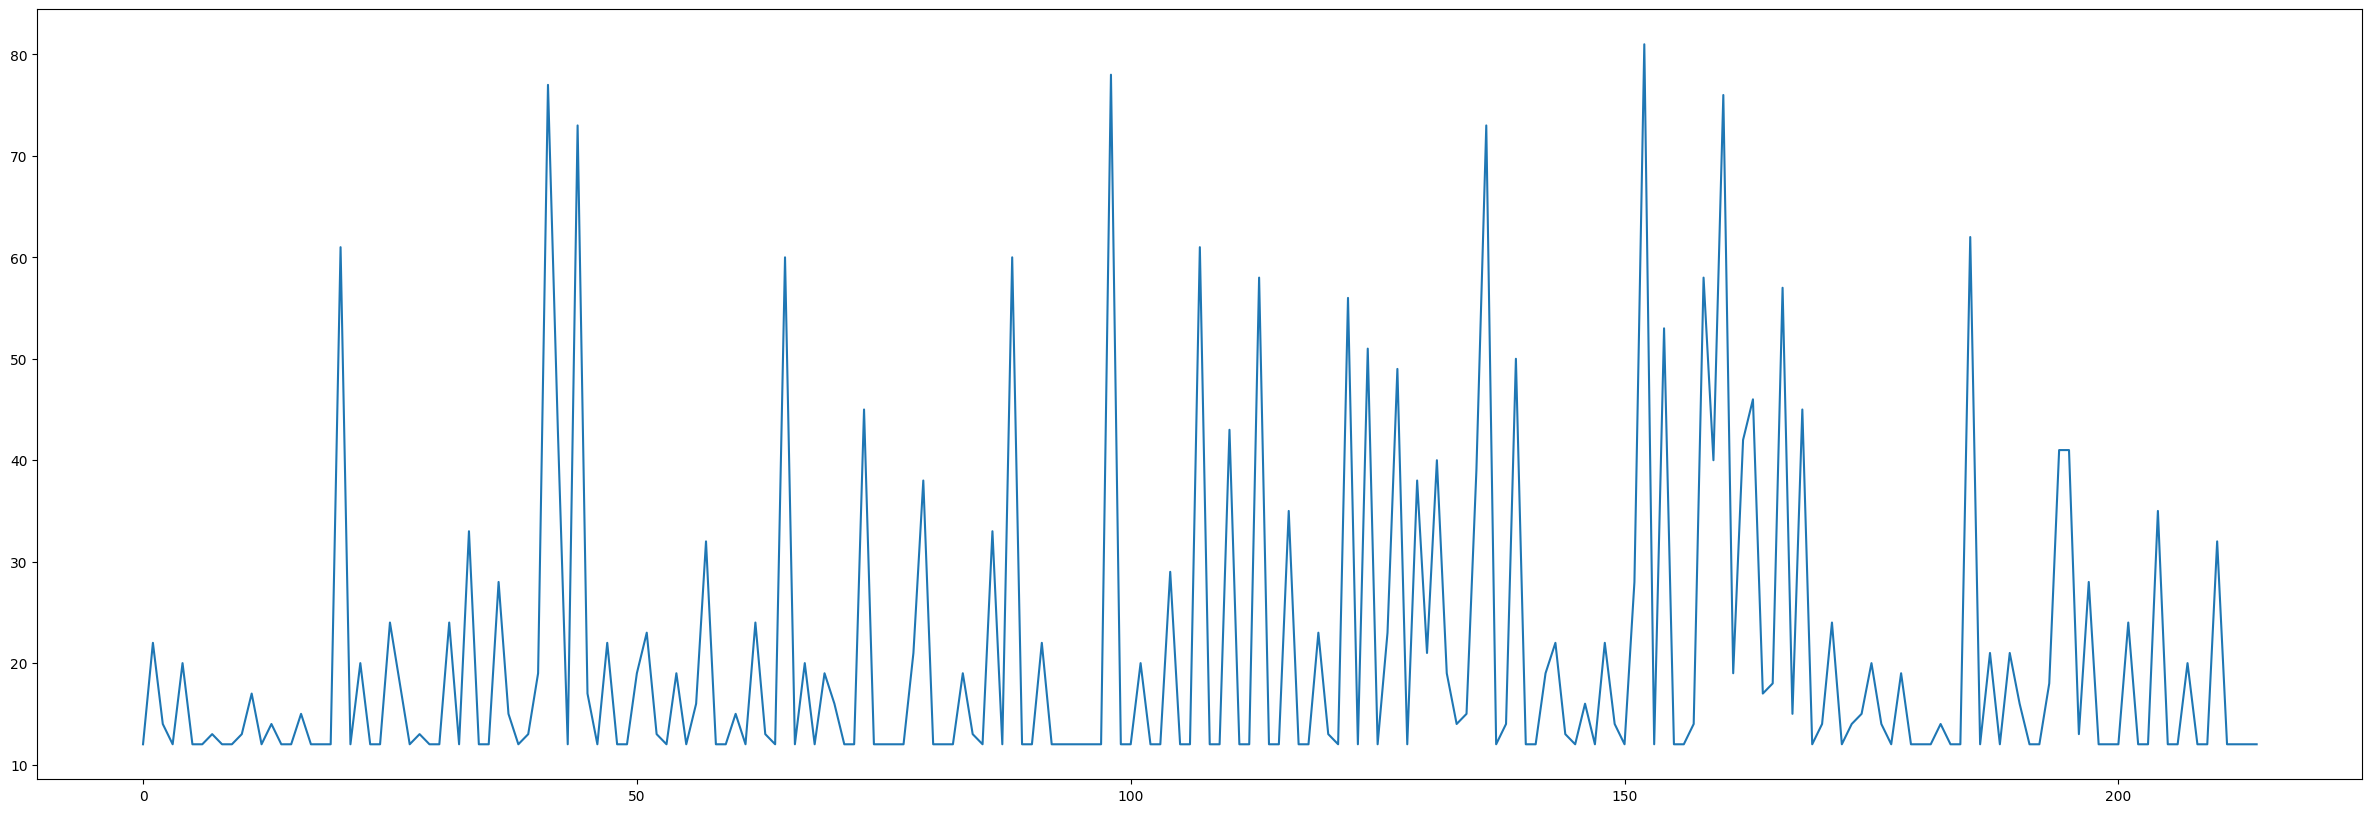

20.98139534883721


In [ ]:
velocity

In [92]:
# variables de registro
df_his = pd.DataFrame(columns=['date', 'vehicle', 'lap', 'ida_Points' , 'stopsPoints', 'Percent_stopPoints', 'links', 'missingStops','list_missingStops'])
df_sp = pd.DataFrame(columns=['link-' + str(i) for i in range(df_linkref.shape[0])])
list_samples = []

# Procesado de datos
for fecha in data['date'].unique():
    data_f = data[data['date'] == fecha]
    print(fecha)
    for veh in vehicles:
        df_veh = data_f[data_f['vehicle_id'] == veh].reset_index(drop=True).copy()
        laps = sorted(df_veh['lap'].unique()[1:-1])

        for lap in laps:
            # filtrar los puntos de ida
            df_veh_lap = idaPoints(df_veh[df_veh['lap'] == lap].reset_index(drop=True))

            # verificar puntos por stop
            df_veh_lap_stop = df_veh_lap.apply(lambda row: searchStopsPoints(row, df_stops), axis=1)
            df_veh_lap_stop = df_veh_lap_stop[df_veh_lap_stop['stop'].notna()].reset_index()

            # filtrar un unico punto por stop
            df_veh_lap_stop.sort_values(by=['stop', 'dis'], ascending=True, inplace=True, ignore_index=True, key=np.int64)
            # df_veh_lap_stop = df_veh_lap_stop.head(df_veh_lap_stop.shape[0]-1).apply(lambda row: midtime(row, df_veh_lap_stop), axis=1)
            df_veh_lap_stop.drop_duplicates(subset=['stop'], keep='first', inplace=True, ignore_index=True)

            # filtrar los stop sin point 
            missing_stops = list(set(df_stops['id']) - set(df_veh_lap_stop['stop'].unique()))
            
            if len(missing_stops) < 24:
                # crear sample
                df_sample = df_linkref.copy()
                df_veh_lap_stop.set_index('stop', inplace=True)
                df_sample = df_sample.apply(lambda row: time_travel(row, df_veh_lap_stop), axis=1)
                list_samples.append(df_sample)

                # registrar metricas
                df_sp.loc[df_sp.shape[0]] = list(df_sample['time_travel'])
                idaP, stopP, links, nNaN = df_veh_lap.shape[0], df_veh_lap_stop.shape[0], df_sample.shape[0], df_sample['time_travel'].isna().sum()
                df_his.loc[df_his.shape[0]] = [fecha, veh, lap, idaP, stopP, stopP/idaP, links/83, len(missing_stops), missing_stops]
                

2023-03-01
2023-03-02
2023-03-03
2023-03-04
2023-03-05
2023-03-06
2023-03-07
2023-03-08
2023-03-09
2023-03-10
2023-03-11
2023-03-12
2023-03-13
2023-03-14
2023-03-15
2023-03-16
2023-03-17
2023-03-18
2023-03-19
2023-03-20
2023-03-21
2023-03-22
2023-03-23
2023-03-24
2023-03-25


In [93]:
csv_temp = pd.concat(list_samples)
csv_temp.to_csv('samples_with_nan.csv')

In [46]:
212480//83

2560

# Procesar samples_with_nan

In [4]:
samples_with_nan = pd.read_csv('samples_with_nan.csv', index_col=None)
# len(samples_with_nan['init_stop'].unique())   #83 paraderos  # 2560 samples con nan
#samples_with_nan['id_sample'] = samples_with_nan.apply(lambda row: int(row.name)//82) 
#samples_with_nan.apply(lambda row: int(row.name))#(//82) 
samples_with_nan['id_sample'] = samples_with_nan.index.map(lambda row: int(row)//83)
columna = samples_with_nan.pop('id_sample') # Extraemos la columna C y la guardamos en una variable
samples_with_nan.insert(0, 'id_sample', columna) # Insertamos la columna C en la posición 1
#samples_with_nan.to_csv('samples_with_nan.csv')
samples_with_nan.to_csv('samples_with_nan.csv', index=False)

In [ ]:
#EJECUTAR CUANDO EXISTA LA COLUMNA UNNAMED 0
samples_with_nan = pd.read_csv('samples_with_nan.csv', index_col=None)
samples_with_nan.drop(columns=['Unnamed: 0'], inplace=True)
samples_with_nan.to_csv('samples_with_nan.csv', index=False)
samples_with_nan

### Filtro de time_travel para moestrar todos los menores a 12 segundos

In [28]:
samples_with_nan = pd.read_csv('samples_with_nan.csv', index_col=None)
#samples_with_nan.nlargest(50,columns='time_travel')
#samples_with_nan[samples_with_nan['time_travel']>=960]['id_sample'].unique #960 segundos equivale a 10 minutos
samples_with_nan[samples_with_nan['time_travel']<12]['id_sample'].unique().shape #960 segundos equivale a 10 minutos

(13,)

# Porcentaje de nan en time_travel

In [33]:
samples_with_nan = pd.read_csv('samples_with_nan.csv', index_col=None)
#samples_with_nan.nsmallest(50,columns='time_travel')
samples_with_nan['time_travel'].isna().sum()/samples_with_nan['time_travel'].shape[0]

0.14896460843373494

## Filtrar por fecha 

In [85]:
samples_with_nan = pd.read_csv('samples_with_nan.csv', index_col=None)
samples_with_nan['date_time_init'] = pd.to_datetime(samples_with_nan['date_time_init'])
samples_with_nan['date_time_end'] = pd.to_datetime(samples_with_nan['date_time_end'])

fecha_filtro = pd.to_datetime('2023-03-12').date()
df_filtrado = samples_with_nan[samples_with_nan['date_time_init'].dt.date == fecha_filtro]
df_filtrado.nsmallest(20, ['time_travel'])

,id_sample,number,init_stop,end_stop,linkref,date_time_init,date_time_end,time_travel,init_idp,end_idp,veh,lap,date
95540,1151,7,42,43,42:43,2023-03-12 11:55:46,2023-03-12 11:55:58,12.0,15047959.0,15047983.0,SJ04,1.0,2023-03-12
95541,1151,8,43,44,43:44,2023-03-12 11:55:58,2023-03-12 11:56:10,12.0,15047983.0,15048008.0,SJ04,1.0,2023-03-12
95553,1151,20,55,56,55:56,2023-03-12 12:10:40,2023-03-12 12:10:52,12.0,15049606.0,15049626.0,SJ04,1.0,2023-03-12
95581,1151,48,83,84,83:84,2023-03-12 12:30:36,2023-03-12 12:30:48,12.0,15052341.0,15052344.0,SJ04,1.0,2023-03-12
95604,1151,71,106,107,106:107,2023-03-12 12:57:31,2023-03-12 12:57:43,12.0,15055259.0,15055291.0,SJ04,1.0,2023-03-12
95606,1151,73,108,109,108:109,2023-03-12 12:57:59,2023-03-12 12:58:11,12.0,15055322.0,15055343.0,SJ04,1.0,2023-03-12
95611,1151,78,113,114,113:114,2023-03-12 13:01:13,2023-03-12 13:01:25,12.0,15055652.0,15055672.0,SJ04,1.0,2023-03-12
95613,1151,80,115,116,115:116,2023-03-12 13:02:27,2023-03-12 13:02:39,12.0,15055782.0,15055803.0,SJ04,1.0,2023-03-12
95614,1151,81,116,117,116:117,2023-03-12 13:02:39,2023-03-12 13:02:51,12.0,15055803.0,15055820.0,SJ04,1.0,2023-03-12
95626,1152,10,45,46,45:46,2023-03-12 06:28:34,2023-03-12 06:28:46,12.0,15013171.0,15013176.0,SJ05,1.0,2023-03-12


In [21]:
list_samples[-1]

,init_stop,end_stop,linkref,date_time_init,date_time_end,time_travel,init_idp,end_idp,veh,lap,date
0,0,36,0:36,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,36,37,36:37,2023-03-25 06:37:58,2023-03-25 06:40:20,142.0,17219295.0,17219581.0,SJ42,1.0,2023-03-25
2,37,38,37:38,2023-03-25 06:40:20,2023-03-25 06:41:37,77.0,17219581.0,17219737.0,SJ42,1.0,2023-03-25
3,38,39,38:39,2023-03-25 06:41:37,2023-03-25 06:42:17,40.0,17219737.0,17219820.0,SJ42,1.0,2023-03-25
4,39,40,39:40,2023-03-25 06:42:17,2023-03-25 06:44:06,109.0,17219820.0,17220046.0,SJ42,1.0,2023-03-25
...,...,...,...,...,...,...,...,...,...,...,...
78,113,114,113:114,2023-03-25 07:51:20,2023-03-25 07:51:32,12.0,17230377.0,17230410.0,SJ42,1.0,2023-03-25
79,114,115,114:115,2023-03-25 07:51:32,2023-03-25 07:53:02,90.0,17230410.0,17230632.0,SJ42,1.0,2023-03-25
80,115,116,115:116,2023-03-25 07:53:02,2023-03-25 07:53:14,12.0,17230632.0,17230662.0,SJ42,1.0,2023-03-25
81,116,117,116:117,2023-03-25 07:53:14,2023-03-25 07:53:26,12.0,17230662.0,17230688.0,SJ42,1.0,2023-03-25


In [22]:
# calcular el promedio
means = []
for col in df_sp.columns:
    means.append(round(df_sp[col].mean(), 0))

print(means)

[102.0, 91.0, 107.0, 46.0, 65.0, 40.0, 34.0, 29.0, 21.0, 35.0, 23.0, 72.0, 119.0, 156.0, 45.0, 34.0, 39.0, 39.0, 31.0, 36.0, 27.0, 44.0, 44.0, 33.0, 35.0, 49.0, 51.0, 34.0, 38.0, 27.0, 31.0, 42.0, 29.0, 51.0, 59.0, 64.0, 33.0, 42.0, 53.0, 58.0, 67.0, 56.0, 64.0, 62.0, 67.0, 93.0, 100.0, 33.0, 44.0, 106.0, 98.0, 52.0, 113.0, 63.0, 75.0, 143.0, 131.0, 100.0, 134.0, 72.0, 83.0, 37.0, 52.0, 32.0, 35.0, 47.0, 39.0, 46.0, 57.0, 70.0, 29.0, 20.0, 20.0, 22.0, 58.0, 39.0, 65.0, 21.0, 15.0, 55.0, 19.0, 15.0, 48.0]


In [35]:
# completar los nan con el promedio
for gg in list_samples:
    i , l_nan = 0, []
    while i < gg.shape[0]:
        if math.isnan(gg.loc[i, 'time_travel']):
            l_nan.append(i)
            gg.loc[i, 'time_travel'] = means[i]
        else:
            if len(l_nan) != 0:
                if 0 not in l_nan:
                    init = datetime.strptime(str(gg.loc[l_nan[0]-1, 'date_time_end']), "%Y-%m-%d %H:%M:%S")  
                    end = datetime.strptime(str(gg.loc[l_nan[-1]+1, 'date_time_init']), "%Y-%m-%d %H:%M:%S")   
                    dis_time = (end - init).total_seconds()
                    me = [means[x] for x in l_nan]
                    tmp = list(map(lambda x: round(dis_time*(x/sum(me)), 0), me))
                    tiempos = dict(zip(l_nan, tmp))
                    for j in l_nan:
                        gg.loc[j, 'time_travel'] = tiempos[j]

                    for k in l_nan:
                        gg.loc[k, 'date_time_init'] = gg.loc[k-1, 'date_time_end']
                        gg.loc[k, 'date_time_end'] = datetime.strptime(str(gg.loc[k, 'date_time_init']), "%Y-%m-%d %H:%M:%S") + timedelta(seconds=gg.loc[k, 'time_travel'])
                else:
                    for k in l_nan[::-1]:
                        gg.loc[k, 'date_time_end'] = gg.loc[k+1, 'date_time_init']
                        gg.loc[k, 'date_time_init'] = datetime.strptime(str(gg.loc[k, 'date_time_end']), "%Y-%m-%d %H:%M:%S") - timedelta(seconds=gg.loc[k, 'time_travel'])
                l_nan = []
        if i == 82 and len(l_nan) != 0:
            for k in l_nan:
                gg.loc[k, 'date_time_init'] = gg.loc[k-1, 'date_time_end']
                gg.loc[k, 'date_time_end'] = datetime.strptime(str(gg.loc[k, 'date_time_init']), "%Y-%m-%d %H:%M:%S") + timedelta(seconds=gg.loc[k, 'time_travel'])
        i += 1

print(list_samples[0].to_string())

   init_stop end_stop  linkref      date_time_init       date_time_end  time_travel    init_idp     end_idp   veh  lap        date
0          0       36     0:36 2023-03-01 07:25:51 2023-03-01 07:27:33        102.0         NaN         NaN   NaN  NaN         NaN
1         36       37    36:37 2023-03-01 07:27:33 2023-03-01 07:29:19        106.0  13190622.0  13190922.0  SJ01  1.0  2023-03-01
2         37       38    37:38 2023-03-01 07:29:19 2023-03-01 07:30:49         90.0  13190922.0  13191197.0  SJ01  1.0  2023-03-01
3         38       39    38:39 2023-03-01 07:30:49 2023-03-01 07:31:13         24.0  13191197.0  13191276.0  SJ01  1.0  2023-03-01
4         39       40    39:40 2023-03-01 07:31:13 2023-03-01 07:32:29         76.0  13191276.0  13191535.0  SJ01  1.0  2023-03-01
5         40       41    40:41 2023-03-01 07:32:29 2023-03-01 07:32:54         25.0  13191535.0  13191620.0  SJ01  1.0  2023-03-01
6         41       42    41:42 2023-03-01 07:32:54 2023-03-01 07:33:25         31.0

In [32]:
csv_temp = pd.concat(list_samples)
csv_temp.to_csv('samples_1v.csv')

In [33]:
len(list_samples)

2560

In [7]:
init = datetime.strptime("2017-05-01 06:27:35", "%Y-%m-%d %H:%M:%S")  
end = datetime.strptime("2017-05-01 06:15:00", "%Y-%m-%d %H:%M:%S")   
dis_time = (end - init).total_seconds()
dis_time

-755.0

In [207]:
fecha = datetime.strptime('2023-03-01 07:40:11', "%Y-%m-%d %H:%M:%S") + timedelta(seconds=32)
print("Fecha original:", fecha)

Fecha original: 2023-03-01 07:40:43


In [ ]:
def curar(row, df):
    print(row.name)
    if math.isnan(row['time_travel']):
        row['time_travel'] = means[row.name]
        if row.name == 0:
            row['date_time_end'] =  df.loc[row.name + 1, 'date_time_init']
            row['date_time_init'] = row['date_time_end'] - datetime.timedelta(seconds= row['time_travel'])
        else:
            row['date_time_init'] =  df.loc[row.name - 1, 'date_time_end']
            row['date_time_end'] =  row['date_time_init'] + datetime.timedelta(seconds= row['time_travel'])
    return row
    

for i, row in gg.iterrows():
        if math.isnan(row['time_travel']):
            travel_t = means[row.name]
            if row.name == 0:
                datetime_end =  gg.loc[i + 1, 'date_time_init']
                datetime_init = datetime_end - datetime.timedelta(seconds=travel_t)
            else:
                datetime_init =  df_af.loc[i - 1, 'date_time_end']
                datetime_end =  datetime_init + datetime.timedelta(seconds=travel_t)
            df_af.loc[df_af.shape[0]] = [row['init_stop'], row['end_stop'], row['linkref'],datetime_init, datetime_end, travel_t, np.nan, np.nan]
        else:
            df_af.loc[df_af.shape[0]] = list(row)

In [ ]:
# list_samples[85]
df_tmp = pd.concat(list_samples)
df_tmp.to_csv('samples.csv', index=False)

In [ ]:
gg = pd.read_csv('samples.csv')
gg

,init_stop,end_stop,linkref,time_travel,init_idp,end_idp
0,0,36,0:36,NaN,NaN,NaN
1,36,37,36:37,106.0,13190622.0,13190922.0
2,37,38,37:38,90.0,13190922.0,13191197.0
3,38,39,38:39,24.0,13191197.0,13191276.0
4,39,40,39:40,76.0,13191276.0,13191535.0
...,...,...,...,...,...,...
212475,113,114,113:114,12.0,17230377.0,17230410.0
212476,114,115,114:115,90.0,17230410.0,17230632.0
212477,115,116,115:116,12.0,17230632.0,17230662.0
212478,116,117,116:117,12.0,17230662.0,17230688.0


In [ ]:
# df_sp.to_csv('df_sp.csv')
df_sp = pd.read_csv('df_sp.csv')
df_sp.mask((df_sp < 0) | (df_sp > 305), np.nan, inplace=True)
df_sp.drop(columns=df_sp.columns[0], inplace=True)
df_sp

,link-0,link-1,link-2,link-3,link-4,link-5,link-6,link-7,link-8,link-9,...,link-73,link-74,link-75,link-76,link-77,link-78,link-79,link-80,link-81,link-82
0,NaN,106.0,90.0,24.0,76.0,25.0,31.0,12.0,12.0,37.0,...,28.0,33.0,56.0,87.0,12.0,12.0,53.0,22.0,14.0,58.0
1,82.0,78.0,100.0,48.0,69.0,36.0,36.0,16.0,35.0,24.0,...,35.0,38.0,54.0,62.0,22.0,12.0,60.0,12.0,12.0,51.0
2,128.0,106.0,135.0,55.0,57.0,42.0,31.0,13.0,33.0,24.0,...,36.0,83.0,55.0,50.0,35.0,NaN,NaN,30.0,12.0,36.0
3,NaN,120.0,81.0,25.0,NaN,NaN,54.0,12.0,14.0,27.0,...,NaN,NaN,39.0,NaN,NaN,NaN,36.0,13.0,12.0,39.0
4,57.0,82.0,84.0,27.0,93.0,46.0,24.0,40.0,29.0,24.0,...,26.0,26.0,71.0,49.0,12.0,23.0,36.0,24.0,15.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,80.0,92.0,89.0,41.0,85.0,24.0,32.0,37.0,19.0,24.0,...,37.0,38.0,52.0,94.0,12.0,12.0,57.0,12.0,NaN,NaN
2556,NaN,152.0,93.0,47.0,70.0,37.0,44.0,41.0,22.0,32.0,...,13.0,75.0,52.0,61.0,12.0,NaN,NaN,12.0,NaN,NaN
2557,NaN,94.0,90.0,43.0,36.0,30.0,54.0,12.0,12.0,48.0,...,NaN,NaN,46.0,NaN,NaN,NaN,52.0,12.0,12.0,47.0
2558,NaN,93.0,98.0,41.0,76.0,24.0,43.0,33.0,21.0,26.0,...,27.0,33.0,68.0,48.0,12.0,12.0,48.0,38.0,12.0,36.0


In [ ]:
# df_his.to_csv('df_his.csv')
df_his = pd.read_csv('df_his.csv')

In [ ]:
for col in df_sp.columns:
    print(df_sp[col].nlargest(50))

2450    305.0
2083    304.0
1129    303.0
164     301.0
2352    300.0
1944    296.0
2089    296.0
2162    294.0
36      293.0
27      290.0
1885    290.0
2336    289.0
622     287.0
2438    285.0
2147    283.0
2195    283.0
547     282.0
1058    282.0
2073    280.0
518     278.0
280     273.0
546     271.0
1178    269.0
2294    269.0
2491    268.0
1941    265.0
1254    264.0
2332    260.0
1109    256.0
2027    251.0
1569    248.0
933     247.0
662     245.0
1614    245.0
2483    243.0
549     242.0
2230    242.0
37      241.0
1666    241.0
2497    238.0
75      237.0
1046    237.0
2137    236.0
2220    236.0
1316    231.0
2099    229.0
2424    227.0
1321    226.0
453     223.0
588     223.0
Name: link-0, dtype: float64
1661    281.0
1553    270.0
1829    258.0
508     217.0
2287    216.0
2156    203.0
2102    202.0
1422    200.0
280     192.0
293     179.0
2280    179.0
2296    179.0
1323    177.0
1147    176.0
423     175.0
91      173.0
1035    173.0
2047    173.0
1247    171.0
2160 

In [ ]:
means = {}
for col in df_sp.columns:
    means[col] = round(df_sp[col].mean(), 2)

means

{'link-0': 103.03,
 'link-1': 91.32,
 'link-2': 107.49,
 'link-3': 45.58,
 'link-4': 65.21,
 'link-5': 40.0,
 'link-6': 33.98,
 'link-7': 29.2,
 'link-8': 21.23,
 'link-9': 35.21,
 'link-10': 23.35,
 'link-11': 71.95,
 'link-12': 119.08,
 'link-13': 156.11,
 'link-14': 44.6,
 'link-15': 34.35,
 'link-16': 38.52,
 'link-17': 38.77,
 'link-18': 31.42,
 'link-19': 35.78,
 'link-20': 27.36,
 'link-21': 43.91,
 'link-22': 43.57,
 'link-23': 33.48,
 'link-24': 34.66,
 'link-25': 49.26,
 'link-26': 50.77,
 'link-27': 33.77,
 'link-28': 38.31,
 'link-29': 26.69,
 'link-30': 30.51,
 'link-31': 41.65,
 'link-32': 29.18,
 'link-33': 50.68,
 'link-34': 59.13,
 'link-35': 63.8,
 'link-36': 32.61,
 'link-37': 42.0,
 'link-38': 52.57,
 'link-39': 58.12,
 'link-40': 67.0,
 'link-41': 55.91,
 'link-42': 64.42,
 'link-43': 61.81,
 'link-44': 66.68,
 'link-45': 92.87,
 'link-46': 100.11,
 'link-47': 32.7,
 'link-48': 43.75,
 'link-49': 105.7,
 'link-50': 98.45,
 'link-51': 51.98,
 'link-52': 112.89,
 'li

In [ ]:
print(df_sp.isna().sum().to_string())

link-0     1544
link-1      169
link-2      121
link-3       99
link-4       97
link-5      248
link-6      350
link-7      272
link-8      198
link-9      174
link-10     167
link-11      95
link-12     230
link-13     286
link-14     530
link-15    1019
link-16     910
link-17     438
link-18     323
link-19     209
link-20     378
link-21     689
link-22     495
link-23     260
link-24     582
link-25     655
link-26     535
link-27     610
link-28     665
link-29     495
link-30     401
link-31     433
link-32     406
link-33     407
link-34     130
link-35      95
link-36     122
link-37     204
link-38     190
link-39     163
link-40     227
link-41     351
link-42     375
link-43     218
link-44     104
link-45     193
link-46     305
link-47     310
link-48     282
link-49     215
link-50     219
link-51     205
link-52     130
link-53      64
link-54      93
link-55     126
link-56     181
link-57     216
link-58     229
link-59     502
link-60     524
link-61     348
link-62 

In [ ]:
df_sp['link-53'].mean(skipna=True)

60.57936507936508

In [ ]:
print(df_sample.to_string())

   init_stop end_stop  linkref  time_travel
0          0       36     0:36          NaN
1         36       37    36:37          NaN
2         37       38    37:38          NaN
3         38       39    38:39          NaN
4         39       40    39:40          NaN
5         40       41    40:41          NaN
6         41       42    41:42          NaN
7         42       43    42:43          NaN
8         43       44    43:44          NaN
9         44       45    44:45          NaN
10        45       46    45:46          NaN
11        46       47    46:47          NaN
12        47       48    47:48          NaN
13        48       49    48:49          NaN
14        49       50    49:50          NaN
15        50       51    50:51          NaN
16        51       52    51:52          NaN
17        52       53    52:53          NaN
18        53       54    53:54          NaN
19        54       55    54:55          NaN
20        55       56    55:56          NaN
21        56       57    56:57  

In [ ]:
print(df_veh_lap_stop.to_string())

      index        id        date      time  lap          latitude_longitude  velocity  navigation vehicle_id           date_time    dis
stop                                                                                                                                    
36        1  17222067  2023-03-25  06:58:44    1  (-13.5550823, -71.8570471)        32         304       SJ01 2023-03-25 06:58:44  40.61
37        7  17222283  2023-03-25  07:00:18    1   (-13.5532574, -71.862231)        33         276       SJ01 2023-03-25 07:00:18  31.27
38       13  17222520  2023-03-25  07:01:54    1  (-13.5521735, -71.8676382)        20         280       SJ01 2023-03-25 07:01:54  39.12
39       16  17222614  2023-03-25  07:02:33    1   (-13.5515218, -71.870422)        20         283       SJ01 2023-03-25 07:02:33  24.11
40       20  17222805  2023-03-25  07:03:57    1  (-13.5506874, -71.8736832)        10         287       SJ01 2023-03-25 07:03:57  31.16
41       23  17222952  2023-03-25  07:04:

In [ ]:
print(f"Rutas admitidas: {df_his[df_his['ida_Points'] > 99].shape[0]}")
print("Rutas no admitidas: ")
empty_stops = []
for i, row in df_his.iterrows(): 
    if row['ida_Points'] <= 99: 
        print(f" veh: {row['vehicle']}, lap: {row['lap']}, nans: {row['ida_Points']}")
        empty_stops += row['stops_nan']

print(Counter(empty_stops))

Rutas admitidas: 112
Rutas no admitidas: 
 veh: SJ01, lap: 5, nans: 1
 veh: SJ05, lap: 0, nans: 26
 veh: SJ09, lap: 1, nans: 30
 veh: SJ18, lap: 4, nans: 20
 veh: SJ31, lap: 2, nans: 4
 veh: SJ34, lap: 6, nans: 2
 veh: SJ36, lap: 2, nans: 27
 veh: SJ38, lap: 0, nans: 12
 veh: SJ38, lap: 2, nans: 36
Counter({'91': 9, '58': 9, '98': 9, '70': 9, '77': 9, '62': 9, '89': 9, '100': 9, '82': 9, '110': 9, '74': 9, '49': 9, '93': 9, '67': 9, '95': 9, '85': 9, '87': 9, '66': 9, '104': 9, '103': 9, '51': 9, '94': 9, '101': 9, '78': 9, '105': 9, '90': 9, '113': 9, '72': 9, '80': 9, '92': 9, '61': 9, '59': 9, '115': 9, '69': 9, '68': 9, '97': 9, '60': 9, '116': 9, '63': 9, '107': 9, '102': 9, '64': 9, '81': 9, '48': 9, '114': 9, '106': 9, '47': 9, '79': 9, '96': 9, '108': 9, '99': 9, '56': 9, '57': 9, '75': 9, '54': 9, '71': 9, '55': 9, '76': 9, '73': 9, '112': 9, '86': 9, '65': 9, '118': 9, '84': 9, '88': 9, '52': 9, '111': 9, '117': 9, '83': 9, '53': 9, '109': 9, '50': 9, '44': 8, '45': 8, '46': 

In [ ]:
print(len(df_his[df_his['Percent_StopPoints'] >= 0.75]))
len(df_his[df_his['Percent_StopPoints'] < 0.75])

101


20

In [ ]:
for i, row in df_his.iterrows():
    if len(row['stops_nan'])!=84:
        print(row['stops_nan'])
        print('-'*30)

{'48', '96', '95', '118'}
------------------------------
{'43', '95', '99', '91', '68', '86', '94', '85', '42'}
------------------------------
{'95'}
------------------------------
{'51', '60', '95'}
------------------------------
{'51', '60', '95'}
------------------------------
{'75', '88', '52', '62', '86', '50', '82', '55', '95', '57', '36', '102', '118', '90', '44', '93', '113', '89', '73', '105', '49', '78', '106', '107', '43', '41', '104', '97', '87', '46', '98', '53', '65', '39', '79', '77', '68', '67', '51', '85', '42', '66', '58', '69', '84', '112', '103', '76', '45', '72', '59', '47', '99', '117', '0', '111', '109', '83', '48', '56', '116', '101', '38', '61', '37', '94'}
------------------------------
{'72', '113', '41', '97', '60', '95', '69', '46', '36', '99', '106', '47', '117', '64', '103', '42'}
------------------------------
{'75', '115', '88', '52', '62', '86', '50', '82', '55', '95', '57', '102', '118', '74', '90', '92', '44', '110', '93', '113', '89', '60', '73', '1

In [ ]:
import numpy as np

numeros = [1, 2, 3, 4, 5]
arreglo = np.array(numeros)

distribucion = np.histogram(arreglo)
distribucion

(array([1, 0, 1, 0, 0, 1, 0, 1, 0, 1], dtype=int64),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]))

In [ ]:
lista

[25.0,
 36.0,
 42.0,
 46.0,
 49.0,
 63.0,
 24.0,
 26.0,
 12.0,
 111.0,
 55.0,
 92.0,
 34.0,
 37.0,
 35.0,
 26.0,
 57.0,
 26.0,
 26.0,
 72.0,
 58.0,
 24.0,
 24.0,
 51.0,
 26.0,
 25.0,
 25.0,
 30.0,
 24.0,
 39.0,
 24.0,
 36.0,
 38.0,
 49.0,
 30.0,
 40.0,
 88.0,
 45.0,
 46.0,
 24.0,
 24.0,
 68.0,
 37.0,
 44.0,
 44.0,
 36.0,
 26.0,
 61.0,
 61.0,
 24.0,
 51.0,
 24.0,
 43.0,
 36.0,
 24.0,
 45.0,
 44.0,
 49.0,
 24.0,
 47.0,
 62.0,
 24.0,
 26.0,
 28.0,
 25.0,
 24.0,
 25.0,
 24.0,
 52.0,
 30.0,
 48.0,
 24.0,
 54.0,
 24.0,
 12248.0,
 24.0,
 32.0,
 44.0,
 48.0,
 24.0,
 25.0,
 48.0,
 25.0,
 31.0,
 64.0,
 24.0,
 25.0,
 12.0,
 24.0,
 25.0,
 24.0,
 41.0,
 69.0,
 38.0,
 46.0,
 67.0,
 24.0,
 54.0,
 26.0,
 66.0,
 33.0,
 63.0,
 24.0,
 25.0,
 46.0,
 24.0,
 65.0,
 33.0,
 37.0,
 50.0,
 24.0,
 31.0,
 24.0,
 51.0,
 30.0,
 56.0,
 25.0,
 40.0,
 25.0,
 27.0,
 31.0,
 36.0,
 72.0,
 24.0,
 33.0,
 47.0,
 37.0,
 30.0,
 12.0,
 47.0,
 83.0,
 118.0,
 47.0,
 24.0,
 37.0,
 24.0,
 24.0,
 25.0,
 24.0,
 49.0,
 28.0,
 50.0,
 

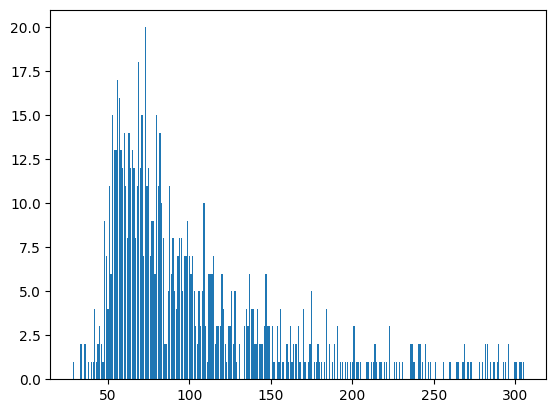

103.02683780630105

In [ ]:
import matplotlib.pyplot as plt

# lista = [1, 2, 3, 1, 2, 3, 3, 3, 4, 5]
lista = list(df_sp['link-0'].dropna())
repeticiones = {}

for n in lista:
    if n in repeticiones:
        repeticiones[n] += 1
    else:
        repeticiones[n] = 1

x = list(repeticiones.keys())
y = list(repeticiones.values())

plt.bar(x, y)
plt.show()

df_sp['link-0'].dropna().mean()

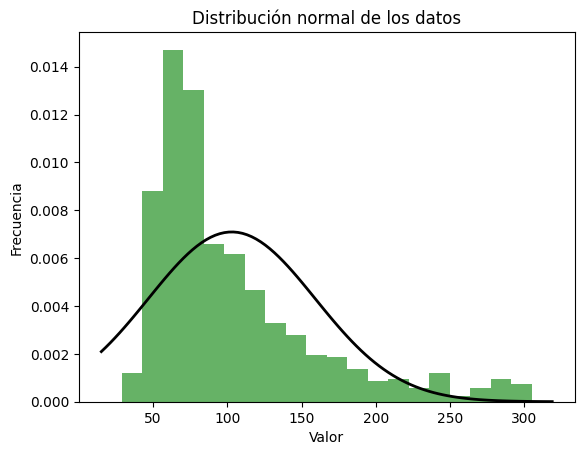

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Generar datos de ejemplo
data = df_sp['link-0'].dropna().to_numpy()

# Ajustar una distribución normal a los datos
mu, std = norm.fit(data)

# Crear un histograma de los datos
plt.hist(data, bins=20, density=True, alpha=0.6, color='g')

# Crear una curva de la distribución normal ajustada
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Añadir etiqueta
# Añadir etiquetas y título
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Distribución normal de los datos')

# Mostrar la gráfica
plt.show()

In [3]:
df_final =  pd.read_csv('samples_1v.csv')
df_final

,number,init_stop,end_stop,linkref,date_time_init,date_time_end,time_travel,init_idp,end_idp,veh,lap,date
0,0,0,36,0:36,2023-03-01 07:25:51,2023-03-01 07:27:33,102.0,NaN,NaN,NaN,NaN,NaN
1,1,36,37,36:37,2023-03-01 07:27:33,2023-03-01 07:29:19,106.0,13190622.0,13190922.0,SJ01,1.0,2023-03-01
2,2,37,38,37:38,2023-03-01 07:29:19,2023-03-01 07:30:49,90.0,13190922.0,13191197.0,SJ01,1.0,2023-03-01
3,3,38,39,38:39,2023-03-01 07:30:49,2023-03-01 07:31:13,24.0,13191197.0,13191276.0,SJ01,1.0,2023-03-01
4,4,39,40,39:40,2023-03-01 07:31:13,2023-03-01 07:32:29,76.0,13191276.0,13191535.0,SJ01,1.0,2023-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...
212475,78,113,114,113:114,2023-03-25 07:51:20,2023-03-25 07:51:32,12.0,17230377.0,17230410.0,SJ42,1.0,2023-03-25
212476,79,114,115,114:115,2023-03-25 07:51:32,2023-03-25 07:53:02,90.0,17230410.0,17230632.0,SJ42,1.0,2023-03-25
212477,80,115,116,115:116,2023-03-25 07:53:02,2023-03-25 07:53:14,12.0,17230632.0,17230662.0,SJ42,1.0,2023-03-25
212478,81,116,117,116:117,2023-03-25 07:53:14,2023-03-25 07:53:26,12.0,17230662.0,17230688.0,SJ42,1.0,2023-03-25


In [ ]:
20170501L0004J0016#030
20170501L0004J0017#030

In [10]:
df_final[['date', 'veh', 'lap']].nunique()

date    25
veh     43
lap      6
dtype: int64

In [5]:
date = '2023-03-01'
veh = 'SJ01'
lap = 3
t = df_final[(df_final['date']==date) & (df_final['veh'] == veh) & (df_final['lap'] == lap)]
print(t.to_string())

     number  init_stop  end_stop  linkref       date_time_init        date_time_end  time_travel    init_idp     end_idp   veh  lap        date
166       0          0        36     0:36  2023-03-01 14:02:05  2023-03-01 14:04:13        128.0  13270545.0  13270960.0  SJ01  3.0  2023-03-01
167       1         36        37    36:37  2023-03-01 14:04:13  2023-03-01 14:05:59        106.0  13270960.0  13271295.0  SJ01  3.0  2023-03-01
168       2         37        38    37:38  2023-03-01 14:05:59  2023-03-01 14:08:14        135.0  13271295.0  13271768.0  SJ01  3.0  2023-03-01
169       3         38        39    38:39  2023-03-01 14:08:14  2023-03-01 14:09:09         55.0  13271768.0  13271922.0  SJ01  3.0  2023-03-01
170       4         39        40    39:40  2023-03-01 14:09:09  2023-03-01 14:10:06         57.0  13271922.0  13272122.0  SJ01  3.0  2023-03-01
171       5         40        41    40:41  2023-03-01 14:10:06  2023-03-01 14:10:48         42.0  13272122.0  13272251.0  SJ01  3.0  202